# Proje: MS Hastaları İçin Engellilik Skoru (EDSS) Tahmini - BaselineCNN

**Amaç:** Bu proje, MS hastalarının beyin MR görüntülerinden doğrudan elde edilen verileri kullanarak, engellilik skorları olan EDSS'i tahmin etmeyi amaçlar.

**Yaklaşım:** Bu bir regresyon problemidir. Girdi olarak lezyon içeren MRI görüntülerini kullanıp, çıktı olarak sürekli bir sayısal değer (EDSS) üreten, sıfırdan eğitilmiş temel bir CNN modeli kullanılacaktır.

# Adım 1: Gerekli Kütüphaneleri Import Etme, Sabit Değişkenleri Atama ve GPU'yu Test Etme

In [1]:
import os
import pandas as pd
import nibabel as nib
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from skimage.transform import resize
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from pathlib import Path
import shutil
from scipy.ndimage import rotate, zoom, gaussian_filter
import random
import glob

from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint,
    TensorBoard
)

In [2]:
TARGET_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 1e-4

MODEL_NAME = 'BaselineCNN_EDSS_Regression.h5'  
OUTPUT_DIR = Path('ML-Models')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
model_ckpt_path = OUTPUT_DIR / MODEL_NAME
METADATA_PATH = "processed_metadata.csv"

LOGS_DIRECTORY = Path('Logs-of-MS-EDSS-BaselineCNN')
if LOGS_DIRECTORY.exists():
    shutil.rmtree(LOGS_DIRECTORY)
LOGS_DIRECTORY.mkdir(parents=True, exist_ok=True)
logdir = LOGS_DIRECTORY

mri_base_path = "../BrainCancerClassification/BrainCancerClassification/Data/MultipleSclerosisMRI"

In [3]:
print("--- Setting up GPU memory ---")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
print("--- GPU setup complete ---")

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

--- Setting up GPU memory ---
1 Physical GPUs, 1 Logical GPUs
--- GPU setup complete ---
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6


# Adım 2: Yardımcı Fonksiyonlar

In [4]:
def load_png(filepath, edss_score):
    """Bir PNG dosyasını okur, decode eder ve float32 formatına çevirir."""
    image = tf.io.read_file(filepath)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, TARGET_SIZE)
    return image, tf.cast(edss_score, tf.float32)

def create_dataset(df, is_training=True):
    """Verilen DataFrame'den bir tf.data.Dataset pipeline oluşturur."""
    
    # Veri artırma katmanları
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.1),
    ], name='gpu_augmentation')

    ds = tf.data.Dataset.from_tensor_slices((df['filepath'].values, df['edss'].values))
    ds = ds.map(load_png, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache()  # Veriyi ilk epoch'tan sonra hafızaya alarak hızlandırır

    if is_training:
        ds = ds.shuffle(buffer_size=len(df))
        # Veri artırmayı uygula
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
        
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE) # Eğitim sırasında veriyi arka planda hazırlar
    return ds

def create_baseline_cnn(input_shape):
    """Sıfırdan eğitilecek temel bir CNN regresyon modeli oluşturur."""
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Feature Extractor (Özellik Çıkarıcı)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    # Regressor Head (Tahminci Kafa)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    outputs = tf.keras.layers.Dense(1, activation='linear', dtype='float32')(x)

    model = tf.keras.Model(inputs, outputs, name="baseline_cnn_regressor")
    return model

# Adım 3: Veri Setini Yükleme ve Bölme

In [5]:
print("İşlenmiş veri metadata'sı okunuyor...")
metadata_df = pd.read_csv(METADATA_PATH)

# Hastaları ayır
unique_patient_ids = metadata_df['patient_id'].unique()
train_val_ids, test_ids = train_test_split(unique_patient_ids, test_size=0.15, random_state=42)
train_ids, val_ids     = train_test_split(train_val_ids, test_size=0.20, random_state=42) 

# Dilim seviyesinde DataFrame'leri oluştur
train_df = metadata_df[metadata_df['patient_id'].isin(train_ids)]
val_df   = metadata_df[metadata_df['patient_id'].isin(val_ids)]
test_df  = metadata_df[metadata_df['patient_id'].isin(test_ids)]

print("\nVeri seti dağılımı:")
print(f"Toplam dilim sayısı: {len(metadata_df)}")
print(f"Eğitim dilim sayısı: {len(train_df)} ({len(train_ids)} hasta)")
print(f"Doğrulama dilim sayısı: {len(val_df)} ({len(val_ids)} hasta)")
print(f"Test dilim sayısı: {len(test_df)} ({len(test_ids)} hasta)")

# tf.data pipeline'larını oluştur
train_dataset = create_dataset(train_df, is_training=True)
val_dataset   = create_dataset(val_df,   is_training=False)
test_dataset  = create_dataset(test_df,  is_training=False)

print("\ntf.data pipeline'ları başarıyla oluşturuldu.")

İşlenmiş veri metadata'sı okunuyor...

Veri seti dağılımı:
Toplam dilim sayısı: 787
Eğitim dilim sayısı: 533 (40 hasta)
Doğrulama dilim sayısı: 152 (11 hasta)
Test dilim sayısı: 102 (9 hasta)

tf.data pipeline'ları başarıyla oluşturuldu.


# Adım 4: Model Eğitimi

In [6]:
# Modeli oluştur
model = create_baseline_cnn((TARGET_SIZE[0], TARGET_SIZE[1], 3))

# Modeli derle
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='huber',  
    metrics=['mae']
)

model.summary()

# Callback'leri tanımla
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7, verbose=1),
    ModelCheckpoint(filepath=model_ckpt_path, monitor='val_loss', save_best_only=True, verbose=1)
]

# Modeli Eğit
print("\nBaseline CNN modelinin eğitimi başlıyor...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks_list,
    verbose=1
)

Model: "baseline_cnn_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 11

# Adım 5: Model Değerlendirme ve Sonuçlar


--- Final Model Değerlendirmesi ---
Test seti üzerinde tahminler yapılıyor...
7/7 [==============================] - 0s 13ms/step
Tahminler tamamlandı.
Performans metrikleri hesaplanıyor...

Final Test Sonuçları:
MSE: 3.9147
MAE: 1.7783
RMSE: 1.9786
R² Skoru: -0.6602


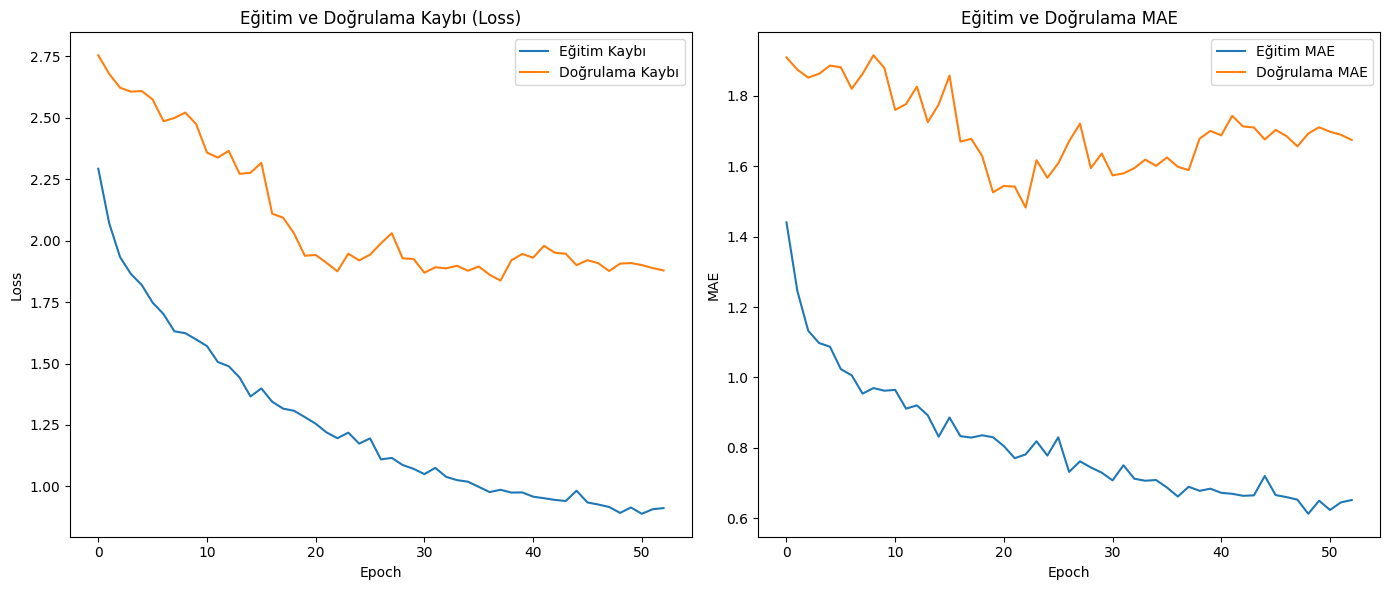

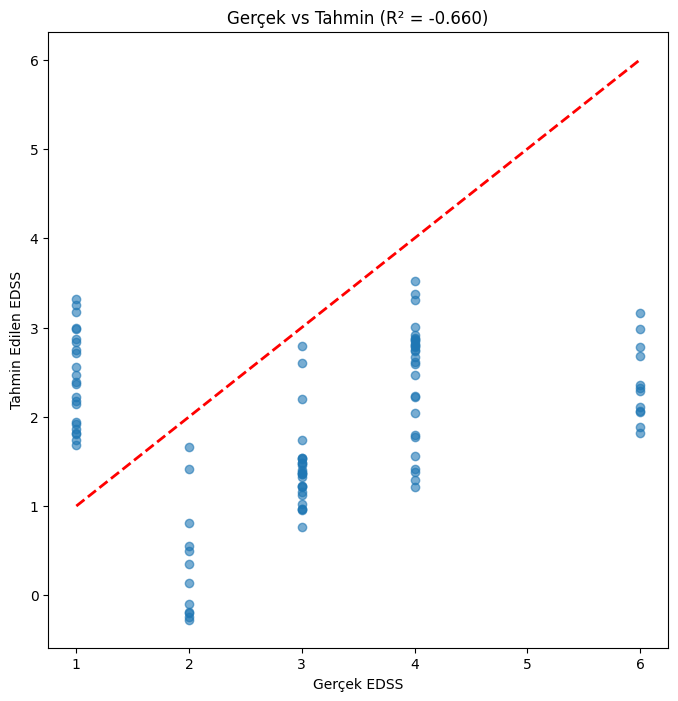


--- Örnek Tahminler ---
Gerçek: 3.00, Tahmin: 1.22, Fark: 1.78
Gerçek: 3.00, Tahmin: 1.02, Fark: 1.98
Gerçek: 3.00, Tahmin: 0.76, Fark: 2.24
Gerçek: 3.00, Tahmin: 0.96, Fark: 2.04
Gerçek: 3.00, Tahmin: 1.36, Fark: 1.64
Gerçek: 3.00, Tahmin: 1.37, Fark: 1.63
Gerçek: 3.00, Tahmin: 1.23, Fark: 1.77
Gerçek: 3.00, Tahmin: 1.21, Fark: 1.79
Gerçek: 3.00, Tahmin: 1.54, Fark: 1.46
Gerçek: 3.00, Tahmin: 1.74, Fark: 1.26


In [7]:
print("\n--- Final Model Değerlendirmesi ---")

print("Test seti üzerinde tahminler yapılıyor...")
y_pred = model.predict(test_dataset).flatten()
y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
print("Tahminler tamamlandı.")

print("Performans metrikleri hesaplanıyor...")
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"\nFinal Test Sonuçları:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Skoru: {r2:.4f}")

# Eğitim ve Doğrulama Grafikleri
plt.figure(figsize=(14, 6))

# Kayıp (Loss) Grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Ortalama Mutlak Hata (MAE) Grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Eğitim MAE')
plt.plot(history.history['val_mae'], label='Doğrulama MAE')
plt.title('Eğitim ve Doğrulama MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

# Gerçek EDSS vs Tahmin Edilen EDSS Grafiği
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.title(f'Gerçek vs Tahmin (R² = {r2:.3f})')
plt.xlabel('Gerçek EDSS')
plt.ylabel('Tahmin Edilen EDSS')
plt.show()

# Örnek Tahminler
print("\n--- Örnek Tahminler ---")
for i in range(min(10, len(y_true))):
    print(f"Gerçek: {y_true[i]:.2f}, Tahmin: {y_pred[i]:.2f}, Fark: {abs(y_true[i] - y_pred[i]):.2f}")